<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Utilities" data-toc-modified-id="Utilities-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utilities</a></span><ul class="toc-item"><li><span><a href="#Pandas-display-options" data-toc-modified-id="Pandas-display-options-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pandas display options</a></span></li><li><span><a href="#Linear-distance-within-a-sphere" data-toc-modified-id="Linear-distance-within-a-sphere-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Linear distance within a sphere</a></span></li><li><span><a href="#Haversine-(great-circle-distance)" data-toc-modified-id="Haversine-(great-circle-distance)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Haversine (great circle distance)</a></span></li><li><span><a href="#Unit-tests" data-toc-modified-id="Unit-tests-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Unit tests</a></span></li></ul></li></ul></div>

# Utilities

In [21]:
from typing import List, Tuple, Sequence, Optional, Dict

import unittest

from math import radians as deg_2_rad, degrees as rad_2_deg
from math import cos, sin, asin, sqrt
import pandas as pd

%matplotlib inline

In [22]:
def hello():
    "Proof of life"
    print('hello from utils')

## Pandas display options

In [23]:
def reset_pd_display(default: bool = False,
                     max_cols: int = None,
                     max_rows: int = None,
                     max_col_width: int = None) -> None:
    " Sets / resets pandas display options. "

    if default:
        resets = ['max_columns', 'max_rows', 'max_colwidth']
        for _ in resets:
            pd.reset_option(_)
        return

    if max_cols:
        pd.set_option('max_columns', max_cols)

    if max_rows:
        pd.set_option('max_rows', max_rows)

    if max_col_width:
        pd.set_option('max_colwidth', max_col_width)

## Linear distance within a sphere

Function to figure out the distance between an earthquake hypocenter and a fracking hypocenter.

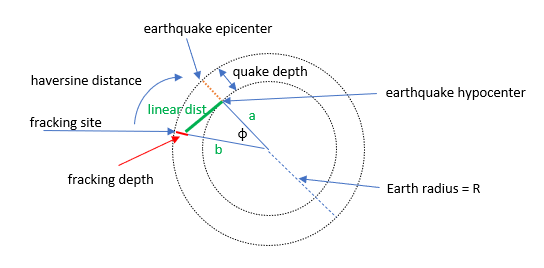

The USGS measures quake depth (km), magnitude, time, and location of every earthquake.   From this we can derive the distance between the actual fracking (typically 2-3 km) and the actual earthquake site (hypocenter).

We want the actual distance between the earthquake hypocenter and the fracking location.   Since we're looking for a causal relationship
fracking -> earthquakes this is reasonable (IMHO).

Using a bit of trig:

a = earth_radius - quake_depth
b = earth_radius - frack_depth
theta = haversine_dist(fracking_site, quake_epicenter) / earth_circumferance

linear_dist = c = a**2 + b**2 = 2*a*b*cos(theta)

In [24]:
def linear_dist_sphere(radius: float, surf_dist: float, depth_a: float, depth_b: float) -> float:
    """ 
    The purpose of this function is to find the actual, linear distance between the hypocenter of 
    and earthquake and the bottom of a fracking well.  It's a more general problem/solution, though:
    
    returns c:  Linear distance through a sphere between two points at or beneath the surface of a sphere
    inputs:
        radius: radius of the sphere;       
        surf_dist: 'great circle' distance between the epicenters of the two points;    
        depth_a, depth_b:  depth of each of the two points beneath the surface.
    
    """
    from math import cos, pi, sqrt
    circumferance = 2 * pi * radius
    theta_rad = (surf_dist / circumferance) * ( 2 * pi )
    
    a = radius - depth_a
    b = radius - depth_b
    c = sqrt(a**2 + b**2 - 2 * a * b * cos(theta_rad))
    return c 

## Haversine (great circle distance)

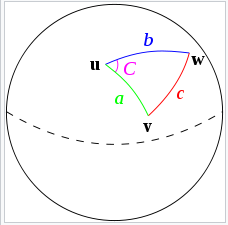

In [25]:
def haversine(long0: float, lat0: float, long1: float, lat1: float) -> float:
    """
    Calculate the surface (great circle) distance between two points 
    on the earth.  Returns distance in km.   
    
    """
    
    RADIUS_EARTH_KM = 6_367  #3956 miles
    
    # Degrees -> radians
    long0, lat0, long1, lat1 = map(radians, [long0, lat0, long1, lat1])
    
    # Haversine formula https://en.wikipedia.org/wiki/Haversine_formula
    dlong = long1 - long0 
    dlat = lat1 - lat0 
    a = sin(dlat/2)**2 + cos(lat0) * cos(lat1) * sin(dlong/2)**2
    c = 2 * asin(sqrt(a)) 
    
    return RADIUS_EARTH_KM * c

In [ ]:
def in_to_pixels(inches, resolution=96):
    "Converts inches to pixels"
    
    return inches * resolution
 

## Unit tests

In [26]:
import unittest
import sys


def run_tests():
    """ Run test in a notebook or command line.  

        Note that this notebook can be onverted to a straight-up 
        *.py script by going:

            $ ipynb-py-convert <notebook name>  <script name>
    """
    
    if 'ipykernel_launcher.py' in sys.argv[0]:
        unittest.main(argv=[''], exit=False)
    else:
        unittest.main()


class UtilTests(unittest.TestCase):
    def test_haversine(self):
        """
        For more distances and geo-coordinates, cf:
          https://www.transtats.bts.gov/Distance.asp
          https://www.latlong.net/category/airports-236-19.html

        Tests are known coordinate and distances between airports.
        """
        tests = (
            {'p0': 'IAD', 'lat0': 38.9531, 'long0':  77.4565, 
             'p1': 'ORD', 'lat1': 41.9803, 'long1': 87.9090, 
             'target': 946.},
            {'p0': 'LAS', 'lat0': 36.1699, 'long0': 115.1398, 
             'p1': 'JFK', 'lat1': 40.6413, 'long1': 73.7781, 
             'target': 3_618.},
            {'p0': 'DEN', 'lat0': 39.8561, 'long0': 104.6737, 
             'p1': 'MCO', 'lat1': 28.4312, 'long1': 81.3081, 
             'target': 2_488.},
        )
        # Test to within 1% of the expected value.
        for t in tests:
            result = haversine(t['long0'], t['lat0'], t['long1'], t['lat1'])
            self.assertAlmostEqual(
                round(result, 0), t['target'], delta=.01*result)

    def test_linear_distance_sphere(self):
        # Test the linear distance between two points, given epicenters and depths; and the radius of the sphere.
        tests = (
            # If the quake and fracking op are at the surface, target distance ~= surface dist
            {'radius': 10, 'surf_dist': 10, 'depth_a': 0, 'depth_b': 0, 'target': 10},

            #  ... that should not depend on the diameter of the Earth.
            {'radius': 1000, 'surf_dist': 10,
             'depth_a': 0, 'depth_b': 0, 'target': 10},

            #  Half way to the middle of the earth, the distance should be half of surface dist
            {'radius': 1000, 'surf_dist': 10,
             'depth_a': 500, 'depth_b': 500, 'target': 5},

            #  Fracking on the surface, earthquake as deep as epicenters are apart makes distance = hyp of a right triangle
            {'radius': 1000, 'surf_dist': 10, 'depth_a': 10,
             'depth_b': 0, 'target': 14.414},
        )
        for t in tests:
            result = linear_dist_sphere(
                t['radius'], t['surf_dist'], t['depth_a'], t['depth_b'])
            self.assertAlmostEqual(result, t['target'], delta=1)


if __name__ == '__main__':
    run_tests()

..
----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK
